# Applying machine learning models on real world data

In this notebook, you will learn how a typical data scientist might go about to do machine learning on real world datasets. As you'll see, most of the time is actually not spent doing machine learning, but rather in preparing, formatting, cleaning and understanding data. 

This notebook is largely based on [this](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html#sphx-glr-auto-examples-02-decoding-plot-haxby-anova-svm-py) and [this](https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-02-decoding-plot-haxby-different-estimators-py) tutorial from `nilearn`.

As usual we start by importing the required libraries. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

We need a dataset to play around with. Scikit-learn has many options in the `datasets` submodule.

In [3]:
# The iris data set available from sklearn contains a number of samples of iris flowers of different species. 
iris = datasets.load_iris()

A description of the dataset can be called like below.

In [4]:
# print(iris.DESCR)

As you see, this data is measurements of flowering plants. The actual data can be accessed using `iris.data`. Data is represented as a matrix, where each row is a unique sample, and the columns represent features. By calling `X.shape` we see that this data set has 150 samples, with 4 features.

In [5]:
X = iris.data
y = iris.target
print(X.shape)

(150, 4)


The species is encoded as a number

In [6]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


**Tip**: Type "iris." into a code cell and press Tab, and a drop down menu will display all the different data fields. Most of these are meta data.

In [7]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### Inspecting your data
Pandas is a wonderful framework for data exploration and visualization.

In [8]:
import pandas as pd
df = pd.DataFrame(X, columns = iris.feature_names)
df['species'] = y # add a column with the prediction target
df.head() # view the first 5 samples

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Check what data type each feature is using `df.dtypes`. These features are numerical, specifically 64 bit floating point (decimal) numbers (float64).

In [9]:
df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
species                int32
dtype: object

This dataset is simple and cleaned, but in the real world, you are more likely to encounter "dirty" datasets, where certain samples have missing values, duplicates or simple typographical errors. Just as a practice, you should get a habit of calling `df.describe()`. Here you can look for outliers and more in the data. Further reading on dirty datasets can be found in the Pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html).

In [10]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


A good habit is to look for duplicates. Here we show how to do so. `df.duplicated()` is an array of boolean values whether the sample occurs multiple times in the dataset.

In [11]:
print(df.duplicated())

0      False
1      False
2      False
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Length: 150, dtype: bool


**Note**: this particular data set does not have very precise decimals, so the likelihood of some samples randomly being identical is relatively high. In fact, we have one false positive

In [12]:
# Check the dataset has duplicates:
np.any(df.duplicated().values)

True

In [13]:
# which is the ((false)) duplicate?
duplicates = df.duplicated()
df[duplicates]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
142,5.8,2.7,5.1,1.9,2


Removing the duplicate would be performed using `df.drop_duplicates`, but we will not need it here. NaN or N/A values represent missing or invalid feats of data. Similarly, we can look for these values using `df.isna()`.

In [14]:
np.any(df.isna().values)

False

`df.dropna()` removes the samples with nan-values from the dataset, and saves you the work of dealing with them. Another option is to fill in NaN-values with the group average for instance. This is done using `df.fillna()`.

### Now that you know some basics of data cleaning, lets visualize the data. We will limit ourselves to only 2 features.

In [53]:
X = iris.data[:, :2] # only use 2 features for visualization purposes
y = iris.target

Always start by plotting your data.

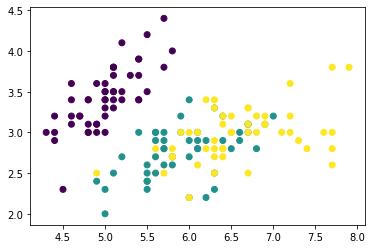

In [16]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

### Making a training and test set

![title](assets/Train_test_sets.jpg)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# random_state ensures the code is reproducible

### Training your model
Training a machine learning model in sklearn is surprisingly concise. The minimum process follows only 2 very easy steps: i) define the model and ii) call the `fit` method, passing the data `X` and labels `y` as arguments.

In [102]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5) # define the model and specify parameters
clf.fit(X_train, y_train) # train the model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Just like that the model is trained, in two lines of code. Now you are left with a trained algorithm `clf`, which you can use to predict the group belonging of new samples.  

**Ex.XX. Test your models performance on the test set by calling the `clf.score` method. Now what happens when you test it on the training set? Why are the two different?**

In [19]:
## Your answer here
#test_score = clf.score(X_test, y_test)
#train_score = clf.score(X_train, y_train)
#print(f"test score: {test_score} \ntrain score: {train_score}")

So far we have excluded 2 out of 4 features in the dataset. **Ex.XX. Retrain the algorithm on the full data, and find its score. Hint: Repeat all the above steps with the full dataset.**

In [20]:
# Your answer here

In [71]:
#answer
X_full = iris.data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0)
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

test score: 0.9666666666666667 
train score: 0.95


**Ex.XX. Explore the train and test score as you let n_neighbors vary. Can you achieve a perfect score on the test set?**

In [ ]:
# your code here

## Feature scaling

So far we have done minimal preprocessing. With few exceptions, you should always do some basic preprocessing, like standardizing each input feature to zero mean and unit variance. In fact, you should **never** do KNN without standardizing the input first. `sklearn` has a great functionality, and offers a vast number of options for preproccesing in the `preprocessing` sub module.

In addition to the `fit` method, many `sklearn` objects have a `transform` method, which lets you transform your dataset. In this case, the transform yields the dataset post normalization.

**Ex XX. plot the dataset X both before and after normalizing, side by side.** Tip: use 

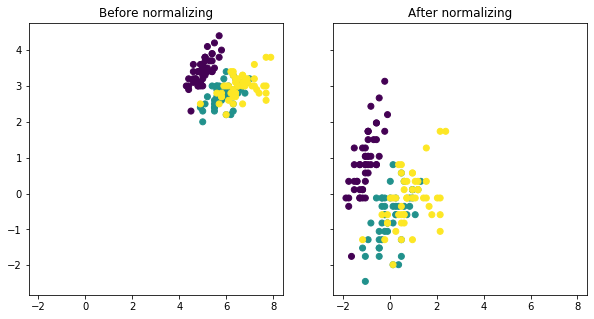

In [104]:
## your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler.fit(X_train) # fit only the training set
X_scaled = scaler.transform(X)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True) # make two plots on the same row
#ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].set_title('Before normalizing') # set the title of the first subplot
#ax[1].scatter(X_scaled[:,0], X_scaled[:,1], c=y) 
ax[1].set_title('After normalizing') # set the title of the second subplot
plt.show()

When using multiple transformers in a single model, you can use a Pipeline, which lets you chain all steps into a single algorithm, as in the following example.

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0)
clf = neighbors.KNeighborsClassifier(n_neighbors=7)
scaler = StandardScaler()

pipe = make_pipeline(scaler, clf)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)

In [23]:
test_score = pipe.score(X_test, y_test)
train_score = pipe.score(X_train, y_train)
print(f"test score: {test_score} \ntrain score: {train_score}")

test score: 1.0 
train score: 0.9666666666666667


For this particular dataset we were already doing quite well before scaling, so it doesn't make a big difference. However, many datasets are very skewed in this regard, so you should simply get used to scaling prior to KNN. The same holds true before doing PCA and SVM and neural networks, but not decision trees. 

### How the choice of K affects the result
An interesting way to visualize the classifier is to look at its decision boundary.

In [106]:
def plot_decision_boundary(clf, X, y):
    """
    X : input data
    y : input labels
    clf : the sklearn classifier
    
    """
    h = .05 
    # Define some custom colors
    cmap_light = ListedColormap(['orange', 'pink', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'red', 'darkblue'])
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

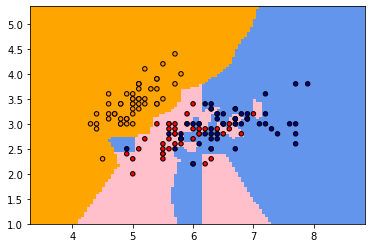

In [107]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf.fit(X_train, y_train)
    
plot_decision_boundary(clf, X, y)
plt.show()

In KNN, the prediction depends on the number of neighbors. **Ex 1: Edit the code below to plot the decision boundary using 1, 11 and 21 neighbors. Explain what you observe**. Hint: write a loop.

In [108]:
# Your code here

#for k in [1, 7, 15]:
#    clf = neighbors.KNeighborsClassifier(n_neighbors = k)
#    clf.fit(X_train, y_train)
#    plot_decision_boundary(clf, X_test, y_test)
#plt.show()

# The decision boundary is more fine-grained for small Ks.

## "Reading thoughts" from brain scans

The most common type of functional magnetic resonance imaging (fMRI) works by recording magnetic field fluctuations inside brains. Blood oxygenation levels is the factor being measured, and is indicative of regional brain activity. Thoughts and other neural processes yields different patterns of brain activity, and thus theory predicts we should be able to discriminate mental states from fMRI scans. This is known as **neural decoding**.

### The Haxby experiment
A pioneering experiment in this field was performed by Haxby et al. (2001), in which they scanned subjects under different visual stimuli: pictures of houses and pictures of human faces (among others). Here we will reproduce the experiment. The library `nilearn` has built in everything we need. 

In [110]:
from nilearn import datasets
from nilearn.plotting import show

We have to download the dataset.

In [111]:
haxby_dataset = datasets.fetch_haxby(fetch_stimuli=True) # only the stimulus, 
stimulus_info = haxby_dataset.stimuli # list of paths for images

In [112]:
# The various categories
stimulus_info.keys()

dict_keys(['bottles', 'cats', 'chairs', 'controls', 'faces', 'houses', 'scissors', 'shoes'])

We can look at the images viewed by the test subjects.

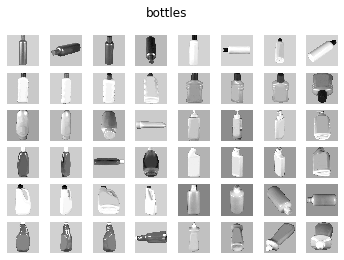

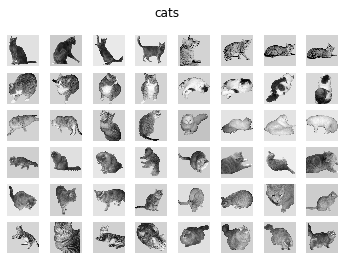

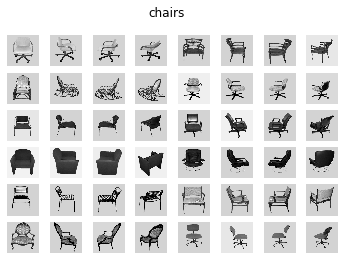

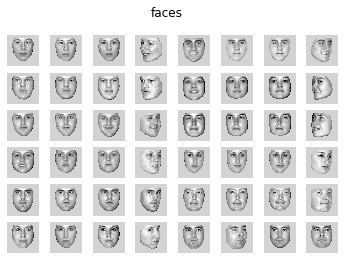

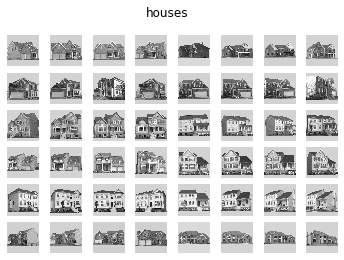

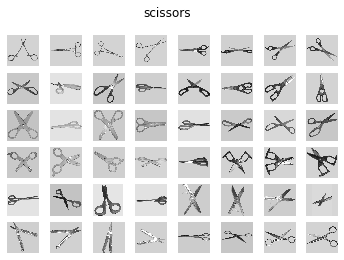

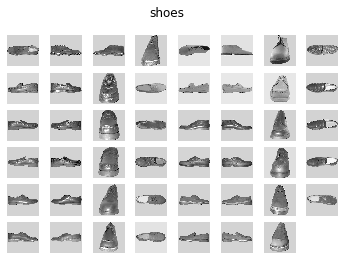

In [113]:
# plot the stimulus 
for stim_type in stimulus_info:
    # skip control images, there are too many
    if stim_type != 'controls':

        file_names = stimulus_info[stim_type]

        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

        for ax in axes.ravel():
            ax.axis("off")

show()

In [114]:
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

Mask nifti image (3D) is located at: C:\Users\Peder/nilearn_data\haxby2001\mask.nii.gz
Functional nifti image (4D) is located at: C:\Users\Peder/nilearn_data\haxby2001\subj2\bold.nii.gz


In [115]:
# First we load a volume. 
from nilearn import image
func_filename = haxby_dataset.func[0] # the first test subject
func_0 = image.load_img(func_filename).slicer[:,:,:,0] # the first volume in the 4D fMRI data

In the machine learning jargon, we consider each voxel (3D pixel) as a *feature*. The vast number of voxels in the image poses a challenge (curse of dimensionality), so we want to do some feature selection before training the classifier. But first: 
**Ex. xx: how many voxels are in the input volume?** 

In [116]:
#Your task is to find out how to access the dimensions. 
# Tip: write "func_0." and press tab to see the options.

# Your code here

In [117]:
# answer
print(f"The zyx-dimensions are {func_0.shape}")
np.prod(func_0.shape) # Total number of features

The zyx-dimensions are (40, 64, 64)


163840

We have to retrieve the labels for each volume (i.e. *what* was the subject looking at?). We have limited ourselves to only two states, so you will have to do some basic data manipulation of the labels. You should carefully read the code below to understand how the data is formatted to fit into the model (Scikit-learn accepts only labels on certain formats, as a one-dimensional numpy array or a pandas Series object).

**Tip:** print the intermediate dataframes to understand what each line of code achieves.

In [118]:
# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

# Restrict the analysis to faces and places
condition_mask = behavioral['labels'].isin(['face', 'house']) # we will only consider two states
y = conditions[condition_mask]

# Confirm that we now have 2 conditions
print(y.unique())

# Record these as an array of sessions, with fields
# for condition (face or house) and run
session = behavioral[condition_mask].to_records(index=False)
print(session.dtype.names)

['face' 'house']
('labels', 'chunks')


So far we have defined the labels `y`. The next step is to defined the data `X` as a (**samples x features**) matrix. In `nilearn`, masker-objects will apply a mask and extract the data from the region and put into a numpy array, `X`. 

In [137]:
from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0] # the first test subject
X = masker.fit_transform(func_filename) # applying the mask
X = X[condition_mask] # selecting only the volumes in condition_mask, i.e. only houses and faces

Now X is on the form that we typically represent data (rows as samples and columns as features). **Ex.XX. a) How many samples do we have in X? b) Compare the shape of X and y**.

In [120]:
# answer: 216. Matrices are always represented in the order: (rows, columns).
# 216 samples, i.e. timepoints
print(X.shape)
print(y.shape)

(216, 39912)
(216,)


Now that the data has been prepared for machine learning, most of the work is behind us. In the next step we can select any classifier and put it to the task. We start with the linear support vector machine (SVM) (called SVC in `sklearn`), which is both effective and fast to train. Because we have roughly 40K features, we select only the most informative ones (this increases both training speed and accuracy). an F-test can help us do so, again available from `sklearn`.

In [135]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 1% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=1)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import make_pipeline
anova_svc = make_pipeline(feature_selection, svc)

### Cross validation

The low **n_samples:n_features** ratio incentivices us to use as many samples as possible for training, while minimizing the test size. We can get an unbiased evaluation of our approach with leave-one-out cross validation. The figure below describes the general process when doing model selection. Here we will deviate slightly by not holding out a final test set.

![title](assets/cross_val.jpg)

In [124]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation on the session group
# which corresponds to a leave-one-session-out
cv = LeaveOneGroupOut()

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X, y, cv=cv, groups=session)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(y.unique())))

Classification accuracy: 0.7824 / Chance level: 0.500000


NB! on study design: because the data is time-continuous, it would be biased if you tried to predict a new time point sitting right in between two already known time points. Because the measurements were divided into *sessions*, we remove a whole session for validation, avoiding the problem of autocorrelation.

### Which brain area is responsible?

So MVPA allows for prediction of mental states from patterns in activity. Now we can ask a biologically interesting question: what part of the brain is responsible for this discrimination of faces and houses? How might you go about to answer such a question? It is surprisingly simple to begin to answer. We can look at the weights assigned by the model. It is not straight-forward to interpret the weights of a SVM, but the information held in `svc.coef_` can be used to weight the importance of the different features. We use the whole dataset 

In [142]:
anova_svc.fit(X, y)
#y_pred = anova_svc.predict(X)

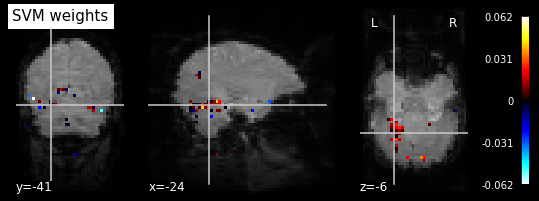

In [143]:
coef = svc.coef_ # the seperating hyperplane is defined by this vector
# reverse feature selection
coef = feature_selection.inverse_transform(coef) # expand to the full 40K voxels
# reverse masking
weight_img = masker.inverse_transform(coef) # Reshape the array of coefs back to 3D to match the MRI volume

# Use the mean image as a background to avoid relying on anatomical data
from nilearn import image
mean_img = image.mean_img(func_filename)

# Create the figure
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Saving the results as a Nifti file may also be important
#weight_img.to_filename('haxby_face_vs_house.nii')

show()